# Train Model with GPT architecture

In [1]:
# change working path to the current file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.backends.cudnn as cudnn

# import custom modules
from models.GPT import *
from utils.utils import *
from datasets.data_loader import *
from utils.plot_figures import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
# read the data and convert to the format we need
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

charset = '?P25$]FO-S.Hc=71(ln63NC4[+)^@'
charlen = len(charset)
print('the charset(inculde begin end and pad char) achieved from dataset :', charset)
print('the total num of charset is :', charlen)
# create the char to index and index to char dictionary
char_to_index = dict((c, i) for i, c in enumerate(charset))
index_to_char = dict((i, c) for i, c in enumerate(charset))
char_list = [k for k, v in char_to_index.items()]

the charset(inculde begin end and pad char) achieved from dataset : ?P25$]FO-S.Hc=71(ln63NC4[+)^@
the total num of charset is : 29


In [5]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 512
epoch = 10
seqlen = 127

In [6]:
src_smiles, tgt_smiles = smiles_padding(train_smiles)
tgt_seq = smiles_to_sequence(tgt_smiles, char_to_index)
tgt_seq = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq]).long()
src_smiles_test, tgt_smiles_test = smiles_padding(test_smiles)
tgt_seq_test = smiles_to_sequence(tgt_smiles_test, char_to_index)
tgt_seq_test = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq_test]).long()
# create the dataset and dataloader
train_dataset = SeqDataset(train_zeo, train_syn, tgt_seq)
test_dataset = SeqDataset(test_zeo, test_syn, tgt_seq_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# create the model
config = GPTConfig(vocab_size=charlen, block_size=128, num_props=24)
model = GPT(config).to(device)
# loss
loss_func = torch.nn.CrossEntropyLoss(reduction='sum').to(device)
optim = torch.optim.Adam(model.parameters(), lr=6e-4)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

total parameters: 3.21M


In [7]:
# train function
def train(model, train_dataloader, loss_func, optim, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt) in enumerate(tqdm(train_dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        # concat zeo and syn as the input (prop)
        synthesis_condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_label = tgt[:, 1:].contiguous()
        tgt_mask = (tgt_label != 0)
        tgt_mask = tgt_mask.to(device)
        optim.zero_grad()
        output = model(idx=tgt_input, prop=synthesis_condition)
        loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
        loss = loss.sum() / tgt_mask.sum()
        loss.backward()
        optim.step()
        total_loss += loss.item()
        total_num += tgt_mask.sum().item()
        acc = (output.argmax(dim=-1) == tgt_label).float()
        acc = acc[tgt_mask].sum()
        total_acc += acc.item()
    return total_loss / total_num, total_acc / total_num

In [8]:
def evaluate(model, test_dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            # concat zeo and syn as the input (prop)
            synthesis_condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_label = tgt[:, 1:].contiguous()
            tgt_mask = (tgt_label != 0)
            tgt_mask = tgt_mask.to(device)
            output = model(idx=tgt_input, prop=synthesis_condition)
            loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
            loss = loss.sum() / tgt_mask.sum()
            total_loss += loss.item()
            total_num += tgt_mask.sum().item()
            acc = (output.argmax(dim=-1) == tgt_label).float()
            acc = acc[tgt_mask].sum()
            total_acc += acc.item()
    return total_loss / total_num, total_acc / total_num

In [9]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, loss_func, optim, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    print('train loss: %.4f, train acc: %.4f' % (train_loss, train_acc))
    test_loss, test_acc = evaluate(model, test_dataloader, loss_func, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    print('test loss: %.4f, test acc: %.4f' % (test_loss, test_acc))
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_best_weight_path + 'best_GPT_model.pth')
    torch.save(model.state_dict(), save_best_weight_path + 'last_GPT_model.pth')

100%|██████████| 284/284 [00:29<00:00,  9.61it/s]


train loss: 0.0001, train acc: 0.4249


100%|██████████| 68/68 [00:02<00:00, 29.30it/s]


test loss: 0.0001, test acc: 687994.0000


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


train loss: 0.0001, train acc: 0.6810


100%|██████████| 68/68 [00:02<00:00, 29.27it/s]


test loss: 0.0000, test acc: 786956.0000


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


train loss: 0.0000, train acc: 0.7370


100%|██████████| 68/68 [00:02<00:00, 29.24it/s]


test loss: 0.0000, test acc: 825026.0000


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


train loss: 0.0000, train acc: 0.7677


100%|██████████| 68/68 [00:02<00:00, 29.27it/s]


test loss: 0.0000, test acc: 847956.0000


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


train loss: 0.0000, train acc: 0.7884


100%|██████████| 68/68 [00:02<00:00, 28.95it/s]


test loss: 0.0000, test acc: 864494.0000


100%|██████████| 284/284 [00:29<00:00,  9.66it/s]


train loss: 0.0000, train acc: 0.8042


100%|██████████| 68/68 [00:02<00:00, 29.25it/s]


test loss: 0.0000, test acc: 877179.0000


100%|██████████| 284/284 [00:29<00:00,  9.66it/s]


train loss: 0.0000, train acc: 0.8163


100%|██████████| 68/68 [00:02<00:00, 29.27it/s]


test loss: 0.0000, test acc: 887556.0000


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


train loss: 0.0000, train acc: 0.8259


100%|██████████| 68/68 [00:02<00:00, 29.29it/s]


test loss: 0.0000, test acc: 895641.0000


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


train loss: 0.0000, train acc: 0.8336


100%|██████████| 68/68 [00:02<00:00, 28.96it/s]


test loss: 0.0000, test acc: 899760.0000


100%|██████████| 284/284 [00:29<00:00,  9.68it/s]


train loss: 0.0000, train acc: 0.8396


100%|██████████| 68/68 [00:02<00:00, 28.95it/s]


test loss: 0.0000, test acc: 904963.0000


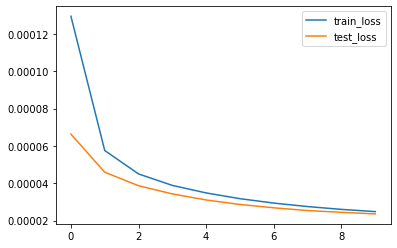

In [11]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'GPT')